In [ ]:
import os
import numpy as np
import torch
import torchvision
from torchvision.transforms import ToTensor
from sklearn.decomposition import PCA
import pennylane as qml
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import save_image
from scipy.linalg import sqrtm
from numpy import cov
from numpy import iscomplexobj
import h5py
import random

-------------------------------------------------------------------------------------

In [ ]:
BATCH_SIZE = 32
epochs = 300
lr = 1e-3
w_decay = 1e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def data_prepare(data_label, root='./dataset/', download=True):
    train_data = torchvision.datasets.MNIST(
        root=root,
        train=True,
        transform=transforms.ToTensor(),
        download=download
    )

    data = []
    for img, label in train_data:
        if label == data_label:
            data.append(img.numpy().squeeze())

    return data

data = np.array(data_prepare(data_label=0))
data = data.reshape(data.shape[0], -1)

k = 2
pca = PCA(n_components=k)
pca.fit(data)
pca_data = pca.transform(data)
t_pca_data = pca_data.copy()
pca_descaler = [[] for _ in range(k)]

for i in range(k):
    if pca_data[:, i].min() < 0:
        pca_descaler[i].append(pca_data[:, i].min())
        pca_data[:, i] += np.abs(pca_data[:, i].min())
    else:
        pca_descaler[i].append(pca_data[:, i].min())
        pca_data[:, i] -= pca_data[:, i].min()
    pca_descaler[i].append(pca_data[:, i].max())
    pca_data[:, i] /= pca_data[:, i].max()

pca_data_rot = np.arcsin(np.sqrt(pca_data))

def descale_points(d_point, scales=pca_descaler, tfrm=pca):
    for col in range(d_point.shape[1]):
        d_point[:, col] *= scales[col][1]
        d_point[:, col] += scales[col][0]
    reconstruction = tfrm.inverse_transform(d_point)
    return reconstruction

n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, w000, w001, w008, w009, w016, w017, w200, w201, w208, w209, w216, w217):
    qml.RY(inputs[0], wires=1)
    qml.RY(inputs[1], wires=2)

    qml.RY(inputs[2], wires=3)
    qml.RY(inputs[3], wires=4)

    qml.RX(w000, wires=1)
    qml.RX(w001, wires=2)

    qml.RY(w008, wires=1)
    qml.RY(w009, wires=2)

    qml.RZ(w016, wires=1)
    qml.RZ(w017, wires=2)
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 1])

    qml.RX(w200, wires=1)
    qml.RX(w201, wires=2)

    qml.RY(w208, wires=1)
    qml.RY(w209, wires=2)

    qml.RZ(w216, wires=1)
    qml.RZ(w217, wires=2)
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 1])

    qml.Hadamard(0)
    qml.CSWAP(wires=[0, 1, 3])
    qml.CSWAP(wires=[0, 2, 4])
    qml.Hadamard(0)

    return qml.probs(wires=[0])

weight_shapes = {"w000": 1, "w001": 1, "w008": 1, "w009": 1, "w016": 1, "w017": 1, "w200": 1, "w201": 1, "w208": 1, "w209": 1, "w216": 1, "w217": 1}

class MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

    def forward(self, x):
        out = self.qlayer(x)
        return out

model = MNIST().to(device)

class Logloss(nn.Module):
    def __init__(self):
        super(Logloss, self).__init__()

    def forward(self, output):
        return torch.mean(-torch.log(output[0]))

In [ ]:

def train(model, device, optimizer, epoch):
    running_loss = 0.0
    loss_sum = 0.0
    output_sum = 0.0
    for i in range(len(pca_data)):
        noise = torch.empty(2, dtype=torch.float32).uniform_(0.3, 0.9).to(device)
        inputs = torch.Tensor(pca_data_rot[i]).to(device)
        inputs = torch.cat((noise, inputs), 0)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_function = Logloss()
        loss = loss_function(outputs)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        running_loss += loss.item()
        output_sum += outputs[0].item()  # Convert to a scalar
        if (i + 1) % 100 == 0:
            print('epoch: %d, loss: %.3f' % (epoch, running_loss / 100))
            running_loss = 0.0

    this_epoch_loss = loss_sum / len(pca_data)
    this_epoch_output = output_sum / len(pca_data)
    return this_epoch_loss, this_epoch_output

def plot_and_save_graphs(loss_list, output_list, epoch):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(loss_list, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(output_list, label='Output')
    plt.xlabel('Epoch')
    plt.ylabel('Output')
    plt.title('Output over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'output_epoch_{epoch}.png')
    plt.close()

def save_sample_images(model, epoch, sample_interval=10):
    if epoch % sample_interval == 0:
        num_samples = 10
        sample_indices = np.random.choice(len(pca_data), num_samples, replace=False)
        samples = pca_data[sample_indices]
        descaled_samples = descale_points(samples)

        fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
        for i, sample in enumerate(descaled_samples):
            axes[i].imshow(sample.reshape(28, 28), cmap='gray')
            axes[i].axis('off')
        plt.tight_layout()
        plt.savefig(f'sample_epoch_{epoch}.png')
        plt.close()

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=30)
highest_acc = 0
loss_list = []
output_list = []

for epoch in range(epochs):
    loss, output = train(model, device, optimizer, epoch)
    loss_list.append(loss)
    output_list.append(output)
    torch.save(model.state_dict(), f'./model_epoch_{epoch}.pth')
    plot_and_save_graphs(loss_list, output_list, epoch)
    save_sample_images(model, epoch, sample_interval=5)

    print("Loss list:", loss_list)
    print("Output list:", output_list)

In [ ]:
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, w000, w001, w008, w009, w016, w017, w200, w201, w208, w209, w216, w217):

    qml.RY(inputs[0], wires=1)
    qml.RY(inputs[1], wires=2)
    qml.RY(inputs[2], wires=3)
    qml.RY(inputs[3], wires=4)


    qml.RX(w000, wires=1)
    qml.RX(w001, wires=2)
    qml.RY(w008, wires=1)
    qml.RY(w009, wires=2)
    qml.RZ(w016, wires=1)
    qml.RZ(w017, wires=2)


    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 1])


    qml.RX(w200, wires=1)
    qml.RX(w201, wires=2)
    qml.RY(w208, wires=1)
    qml.RY(w209, wires=2)
    qml.RZ(w216, wires=1)
    qml.RZ(w217, wires=2)


    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 1])


    qml.Hadamard(0)
    qml.CSWAP(wires=[0, 1, 3])
    qml.CSWAP(wires=[0, 2, 4])
    qml.Hadamard(0)

    return qml.probs(wires=[0])


inputs = np.array([0.1, 0.2, 0.3, 0.4])
weights = np.random.random(12)

drawer = qml.draw(qnode)
print(drawer(inputs, *weights))

fig, ax = qml.draw_mpl(qnode)(inputs, *weights)
plt.show()

## Jet Images


In [ ]:
import h5py
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import pennylane as qml

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
jet_images_path = 'jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
with h5py.File(jet_images_path, 'r') as jet_mass_data:
    X_jet = jet_mass_data['image']
    print("Original shape:", X_jet.shape)
    X_jet = np.array(X_jet)
    X_jet = torch.tensor(X_jet, dtype=torch.float32)

# Normalize and resize images
X_jet = (X_jet - X_jet.min()) / (X_jet.max() - X_jet.min())
X_jet = X_jet.unsqueeze(1)
X_jet_resized = nn.functional.interpolate(X_jet, size=(16, 16), mode='bilinear', align_corners=False)
print("Resized shape:", X_jet_resized.shape)

# Sample data
indices = random.sample(range(X_jet_resized.shape[0]), 10000)
X_jet_sampled = X_jet_resized[indices]
print("Sampled shape:", X_jet_sampled.shape)

# Flatten the images for PCA
X_jet_flat = X_jet_sampled.view(X_jet_sampled.size(0), -1)

In [ ]:
from sklearn.decomposition import PCA

k = 2
pca = PCA(n_components=k)
pca.fit(X_jet_flat)
pca_data = pca.transform(X_jet_flat)
t_pca_data = pca_data.copy()
pca_descaler = [[] for _ in range(k)]

for i in range(k):
    if pca_data[:, i].min() < 0:
        pca_descaler[i].append(pca_data[:, i].min())
        pca_data[:, i] += np.abs(pca_data[:, i].min())
    else:
        pca_descaler[i].append(pca_data[:, i].min())
        pca_data[:, i] -= pca_data[:, i].min()
    pca_descaler[i].append(pca_data[:, i].max())
    pca_data[:, i] /= pca_data[:, i].max()

pca_data_rot = np.arcsin(np.sqrt(pca_data))

In [ ]:
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, w000, w001, w008, w009, w016, w017, w200, w201, w208, w209, w216, w217):
    qml.RY(inputs[0], wires=1)
    qml.RY(inputs[1], wires=2)

    qml.RY(inputs[2], wires=3)
    qml.RY(inputs[3], wires=4)

    qml.RX(w000, wires=1)
    qml.RX(w001, wires=2)

    qml.RY(w008, wires=1)
    qml.RY(w009, wires=2)

    qml.RZ(w016, wires=1)
    qml.RZ(w017, wires=2)
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 1])

    qml.RX(w200, wires=1)
    qml.RX(w201, wires=2)

    qml.RY(w208, wires=1)
    qml.RY(w209, wires=2)

    qml.RZ(w216, wires=1)
    qml.RZ(w217, wires=2)
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 1])

    qml.Hadamard(0)
    qml.CSWAP(wires=[0, 1, 3])
    qml.CSWAP(wires=[0, 2, 4])
    qml.Hadamard(0)

    return qml.probs(wires=[0])

weight_shapes = {"w000": 1, "w001": 1, "w008": 1, "w009": 1, "w016": 1, "w017": 1, "w200": 1, "w201": 1, "w208": 1, "w209": 1, "w216": 1, "w217": 1}

class QuantumGAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

    def forward(self, x):
        out = self.qlayer(x)
        return out

model = QuantumGAN().to(device)

In [ ]:
def plot_and_save_graphs(loss_list, output_list, epoch):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(loss_list, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(output_list, label='Output')
    plt.xlabel('Epoch')
    plt.ylabel('Output')
    plt.title('Output over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'output_Jet_IQGAN_epoch_{epoch}.png')
    plt.close()

def descale_points(d_point, scales=pca_descaler, tfrm=pca):
    for col in range(d_point.shape[1]):
        d_point[:, col] *= scales[col][1]
        d_point[:, col] += scales[col][0]
    reconstruction = tfrm.inverse_transform(d_point)
    return reconstruction


In [ ]:
import matplotlib.pyplot as plt
def plot_generated_samples(model, epoch, num_samples=16):
    with torch.no_grad():
        # Generate random latent vectors
        z = torch.randn(num_samples, 4).to(device)  # Adjust the size to match the expected input
        generated_data = model(z).cpu().numpy()
        generated_data = pca.inverse_transform(generated_data)

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        img = generated_data[i].reshape(16, 16)
        axes[i].imshow(img, cmap='viridis')
        axes[i].axis('off')
    plt.show()
    plt.close()

In [ ]:
def save_sample_images(model, epoch, sample_interval=1):
    if epoch % sample_interval == 0:
        num_samples = 10
        sample_indices = np.random.choice(len(pca_data), num_samples, replace=False)
        samples = pca_data[sample_indices]
        descaled_samples = descale_points(samples)

        fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
        for i, sample in enumerate(descaled_samples):
            axes[i].imshow(sample.reshape(16, 16), cmap='viridis')
            axes[i].axis('off')
        plt.tight_layout()
        plt.savefig(f'IQGAN_jet_epoch_{epoch}.png')
        plt.close()

In [ ]:
BATCH_SIZE = 32
epochs = 30
lr = 1e-3
w_decay = 1e-4

class Logloss(nn.Module):
    def __init__(self):
        super(Logloss, self).__init__()

    def forward(self, output):
        return torch.mean(-torch.log(output[0]))

def train(model, device, optimizer, epoch):
    running_loss = 0.0
    loss_sum = 0.0
    output_sum = 0.0
    for i in range(len(pca_data)):
        noise = torch.empty(2, dtype=torch.float32).uniform_(0.3, 0.9).to(device)
        inputs = torch.Tensor(pca_data_rot[i]).to(device)
        inputs = torch.cat((noise, inputs), 0)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_function = Logloss()
        loss = loss_function(outputs)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        running_loss += loss.item()
        output_sum += outputs[0].item()
        if (i + 1) % 200 == 0:
            print('epoch: %d, loss: %.3f' % (epoch, running_loss / 100))
            running_loss = 0.0

    this_epoch_loss = loss_sum / len(pca_data)
    this_epoch_output = output_sum / len(pca_data)
    return this_epoch_loss, this_epoch_output

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=30)
highest_acc = 0
loss_list = []
output_list = []

for epoch in range(epochs):
    loss, output = train(model, device, optimizer, epoch)
    loss_list.append(loss)
    output_list.append(output)
    # torch.save(model.state_dict(), f'./model_epoch_{epoch}.pth')
    plot_and_save_graphs(loss_list, output_list, epoch)
    save_sample_images(model, epoch, sample_interval=1)
    # plot_generated_samples(model, epoch)

    print("Loss list:", loss_list)
    print("Output list:", output_list)

## Circuit Experimentation



### Entanglement based

Note that the FID scores aren't the right values and are not comparable with classical ones


#### Full entanglement

In [ ]:
k = 2
pca = PCA(n_components=k)
pca.fit(X_jet_flat)
pca_data = pca.transform(X_jet_flat)
t_pca_data = pca_data.copy()
pca_descaler = [[] for _ in range(k)]

for i in range(k):
    if pca_data[:, i].min() < 0:
        pca_descaler[i].append(pca_data[:, i].min())
        pca_data[:, i] += np.abs(pca_data[:, i].min())
    else:
        pca_descaler[i].append(pca_data[:, i].min())
        pca_data[:, i] -= pca_data[:, i].min()
    pca_descaler[i].append(pca_data[:, i].max())
    pca_data[:, i] /= pca_data[:, i].max()

pca_data_rot = np.arcsin(np.sqrt(pca_data))


n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)

In [ ]:
@qml.qnode(dev)
def qnode(inputs, w000, w001, w008, w009, w016, w017, w200, w201, w208, w209, w216, w217):
    # Input encoding
    qml.RY(inputs[0], wires=1)
    qml.RY(inputs[1], wires=2)

    # Parametrized gates
    qml.RX(w000, wires=1)
    qml.RX(w001, wires=2)

    # Full entanglement
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[1, 3])
    qml.CNOT(wires=[1, 4])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[2, 4])
    qml.CNOT(wires=[3, 4])

    # Remaining gates and measurements
    qml.Hadamard(0)
    qml.CSWAP(wires=[0, 1, 3])
    qml.CSWAP(wires=[0, 2, 4])
    qml.Hadamard(0)

    return qml.probs(wires=[0])

weight_shapes = {"w000": 1, "w001": 1, "w008": 1, "w009": 1, "w016": 1, "w017": 1, "w200": 1, "w201": 1, "w208": 1, "w209": 1, "w216": 1, "w217": 1}

In [ ]:
class QuantumGAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

    def forward(self, x):
        out = self.qlayer(x)
        return out

model = QuantumGAN().to(device)

In [ ]:
selected_jet_image = pca_data_rot[0]

@qml.qnode(dev)
def encode_jet_image_into_state():
    # Input encoding
    qml.RY(selected_jet_image[0], wires=1)
    qml.RY(selected_jet_image[1], wires=2)

    return qml.state()

# Get the reference state by running the quantum node
reference_state = encode_jet_image_into_state()

In [ ]:
def calculate_fidelity(generated_state, reference_state):
    fidelity = np.abs(np.dot(np.conj(reference_state), generated_state)) ** 2
    return fidelity

reference_state = np.array([1, 0])

In [ ]:


def generate_samples(model, num_samples=10):
    model.eval()
    with torch.no_grad():
        latent_vectors = np.random.uniform(0, 1, size=(num_samples, k))  # k is 2 as used in PCA
        latent_vectors_rot = np.arcsin(np.sqrt(latent_vectors))

        generated_samples = []
        for vec in latent_vectors_rot:
            noise = torch.empty(2, dtype=torch.float32).uniform_(0.3, 0.9).cpu()  # Ensure it's on the CPU
            vec_tensor = torch.Tensor(vec).cpu()  # Ensure vec is on the CPU
            input_tensor = torch.cat((noise, vec_tensor)).to(device)  # Move concatenated tensor to the device
            output = model(input_tensor)
            generated_samples.append(output.cpu().numpy())  # Move output back to CPU before converting to NumPy

        return np.array(generated_samples)

def descale_points(d_point, scales=pca_descaler, tfrm=pca):
    for col in range(d_point.shape[1]):
        d_point[:, col] *= scales[col][1]
        d_point[:, col] += scales[col][0]
    reconstruction = tfrm.inverse_transform(d_point)
    return reconstruction

def visualize_generated_samples(generated_samples, num_samples=10):
    descaled_samples = descale_points(generated_samples)  # Descale from PCA back to image space

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
    for i, sample in enumerate(descaled_samples):
        axes[i].imshow(sample.reshape(16, 16), cmap='viridis')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

def calculate_fid(real_samples, generated_samples):
    # Flatten the images
    real_samples_flattened = real_samples.reshape(real_samples.shape[0], -1)
    generated_samples_flattened = generated_samples.reshape(generated_samples.shape[0], -1)

    # Compute the mean and covariance of the real and generated samples
    mu_real = np.mean(real_samples_flattened, axis=0)
    sigma_real = np.cov(real_samples_flattened, rowvar=False)

    mu_gen = np.mean(generated_samples_flattened, axis=0)
    sigma_gen = np.cov(generated_samples_flattened, rowvar=False)

    # Compute FID using the formula
    fid = np.sum((mu_real - mu_gen) ** 2) + np.trace(sigma_real + sigma_gen - 2.0 * sqrtm(sigma_real @ sigma_gen))

    # Sometimes sqrtm may result in complex numbers, taking only the real part if necessary
    if np.iscomplexobj(fid):
        fid = fid.real

    return fid

def save_sample_images(model, epoch, sample_interval=1):
    if epoch % sample_interval == 0:
        num_samples = 10
        sample_indices = np.random.choice(len(pca_data), num_samples, replace=False)
        samples = pca_data[sample_indices]
        descaled_samples = descale_points(samples)

        fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
        for i, sample in enumerate(descaled_samples):
            axes[i].imshow(sample.reshape(16, 16), cmap='viridis')
            axes[i].axis('off')
        plt.tight_layout()
        plt.savefig(f'IQGAN_jet_test1_{epoch}.png')
        plt.close()

class Logloss(nn.Module):
    def __init__(self):
        super(Logloss, self).__init__()

    def forward(self, output):
        return torch.mean(-torch.log(output[0]))

def train(model, device, optimizer, epoch):
    running_loss = 0.0
    loss_sum = 0.0
    output_sum = 0.0
    fidelity_sum = 0.0
    for i in range(len(pca_data)):
        noise = torch.empty(2, dtype=torch.float32).uniform_(0.3, 0.9).to(device)
        inputs = torch.Tensor(pca_data_rot[i]).to(device)
        inputs = torch.cat((noise, inputs), 0)
        optimizer.zero_grad()
        generated_state = model(inputs)
        loss_function = Logloss()
        loss = loss_function(generated_state)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        running_loss += loss.item()
        output_sum += generated_state[0].item()

        # Calculate fidelity for each generated state
        fidelity = calculate_fidelity(generated_state.cpu().detach().numpy(), reference_state)
        fidelity_sum += fidelity

        if (i + 1) % 200 == 0:
            print('epoch: %d, loss: %.3f, fidelity: %.3f' % (epoch, running_loss / 100, fidelity_sum / 200))
            running_loss = 0.0

    this_epoch_loss = loss_sum / len(pca_data)
    this_epoch_output = output_sum / len(pca_data)
    this_epoch_fidelity = fidelity_sum / len(pca_data)

    return this_epoch_loss, this_epoch_output, this_epoch_fidelity

# Training parameters
BATCH_SIZE = 32
epochs = 30
lr = 1e-3
w_decay = 1e-4

In [ ]:
def plot_and_save_graphs(loss_list, output_list, fidelity_list, epoch):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(loss_list, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(output_list, label='Output')
    plt.xlabel('Epoch')
    plt.ylabel('Output')
    plt.title('Output over Epochs')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(fidelity_list, label='Fidelity')
    plt.xlabel('Epoch')
    plt.ylabel('Fidelity')
    plt.title('Fidelity over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'IQGAN_jet_test1_plots_{epoch}.png')
    plt.close()


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=30)
highest_acc = 0
loss_list = []
output_list = []
fidelity_list = []
fid_list = []

for epoch in range(epochs):
    loss, output, fidelity = train(model, device, optimizer, epoch)
    loss_list.append(loss)
    output_list.append(output)
    fidelity_list.append(fidelity)

    # Generate samples at each epoch and calculate FID
    generated_samples = generate_samples(model, num_samples=100)
    descaled_generated_samples = descale_points(generated_samples)
    descaled_generated_samples = descaled_generated_samples.reshape(100, 16, 16)

    # Take a batch of real images for comparison
    real_images = X_jet_resized[indices[:100]].cpu().numpy()

    fid = calculate_fid(real_images, descaled_generated_samples)
    fid_list.append(fid)

    print(f'Epoch {epoch}: Loss = {loss}, FID = {fid}')
    save_sample_images(model, epoch, sample_interval=1)

    print("Loss list:", loss_list)
    print("Output list:", output_list)
    print("FID list:", fid_list)
    print("Fidelity list:", fidelity_list)
plot_and_save_graphs(loss_list, output_list, fidelity_list, epoch)

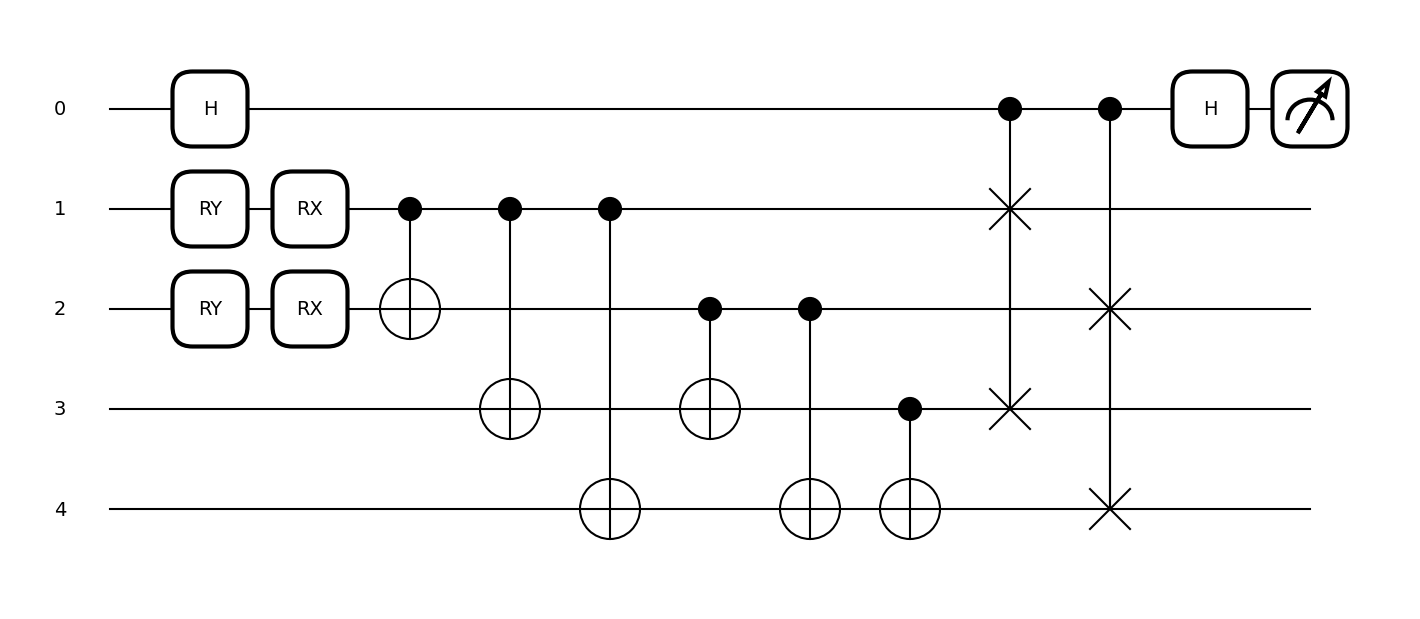

In [ ]:
fig, ax = qml.draw_mpl(qnode)(inputs=[0.5, 0.2], w000=0.1, w001=0.1, w008=0.1, w009=0.1, w016=0.1, w017=0.1, w200=0.1, w201=0.1, w208=0.1, w209=0.1, w216=0.1, w217=0.1)
plt.show()

In [ ]:
circuit_specs = qml.specs(qnode)
print(circuit_specs(inputs=[0.5, 0.2], w000=0.1, w001=0.1, w008=0.1, w009=0.1, w016=0.1, w017=0.1, w200=0.1, w201=0.1, w208=0.1, w209=0.1, w216=0.1, w217=0.1))

{'resources': Resources(num_wires=5, num_gates=14, gate_types=defaultdict(<class 'int'>, {'RY': 2, 'RX': 2, 'CNOT': 6, 'Hadamard': 2, 'CSWAP': 2}), gate_sizes=defaultdict(<class 'int'>, {1: 6, 2: 6, 3: 2}), depth=10, shots=Shots(total_shots=None, shot_vector=())), 'errors': {}, 'num_observables': 1, 'num_diagonalizing_gates': 0, 'num_trainable_params': 0, 'num_device_wires': 5, 'device_name': 'default.qubit', 'expansion_strategy': 'gradient', 'gradient_options': {}, 'interface': 'torch', 'diff_method': 'best', 'gradient_fn': 'backprop'}


#### Circular Entanglement

In [ ]:
@qml.qnode(dev)
def qnode(inputs, w000, w001, w008, w009, w016, w017, w200, w201, w208, w209, w216, w217):
    # Input encoding
    qml.RY(inputs[0], wires=1)
    qml.RY(inputs[1], wires=2)

    # Parametrized gates
    qml.RX(w000, wires=1)
    qml.RX(w001, wires=2)

    # Circular entanglement
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 4])
    qml.CNOT(wires=[4, 1])

    # Remaining gates and measurements
    qml.Hadamard(0)
    qml.CSWAP(wires=[0, 1, 3])
    qml.CSWAP(wires=[0, 2, 4])
    qml.Hadamard(0)

    return qml.probs(wires=[0])

weight_shapes = {"w000": 1, "w001": 1, "w008": 1, "w009": 1, "w016": 1, "w017": 1, "w200": 1, "w201": 1, "w208": 1, "w209": 1, "w216": 1, "w217": 1}

In [ ]:
class QuantumGAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

    def forward(self, x):
        out = self.qlayer(x)
        return out

model = QuantumGAN().to(device)

In [ ]:
def save_sample_images(model, epoch, sample_interval=1):
    if epoch % sample_interval == 0:
        num_samples = 10
        sample_indices = np.random.choice(len(pca_data), num_samples, replace=False)
        samples = pca_data[sample_indices]
        descaled_samples = descale_points(samples)

        fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
        for i, sample in enumerate(descaled_samples):
            axes[i].imshow(sample.reshape(16, 16), cmap='viridis')
            axes[i].axis('off')
        plt.tight_layout()
        plt.savefig(f'IQGAN_jet_test2_{epoch}.png')
        plt.close()


In [ ]:
def plot_and_save_graphs(loss_list, output_list, fidelity_list, epoch):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(loss_list, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(output_list, label='Output')
    plt.xlabel('Epoch')
    plt.ylabel('Output')
    plt.title('Output over Epochs')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(fidelity_list, label='Fidelity')
    plt.xlabel('Epoch')
    plt.ylabel('Fidelity')
    plt.title('Fidelity over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'IQGAN_jet_test2_plots_{epoch}.png')
    plt.close()


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=30)
highest_acc = 0
loss_list = []
output_list = []
fidelity_list = []
fid_list = []

for epoch in range(epochs):
    loss, output, fidelity = train(model, device, optimizer, epoch)
    loss_list.append(loss)
    output_list.append(output)
    fidelity_list.append(fidelity)

    # Generate samples at each epoch and calculate FID
    generated_samples = generate_samples(model, num_samples=100)
    descaled_generated_samples = descale_points(generated_samples)
    descaled_generated_samples = descaled_generated_samples.reshape(100, 16, 16)

    # Take a batch of real images for comparison
    real_images = X_jet_resized[indices[:100]].cpu().numpy()

    fid = calculate_fid(real_images, descaled_generated_samples)
    fid_list.append(fid)

    print(f'Epoch {epoch}: Loss = {loss}, FID = {fid}')
    save_sample_images(model, epoch, sample_interval=1)

    print("Loss list:", loss_list)
    print("Output list:", output_list)
    print("FID list:", fid_list)
    print("Fidelity list:", fidelity_list)
plot_and_save_graphs(loss_list, output_list, fidelity_list, epoch)

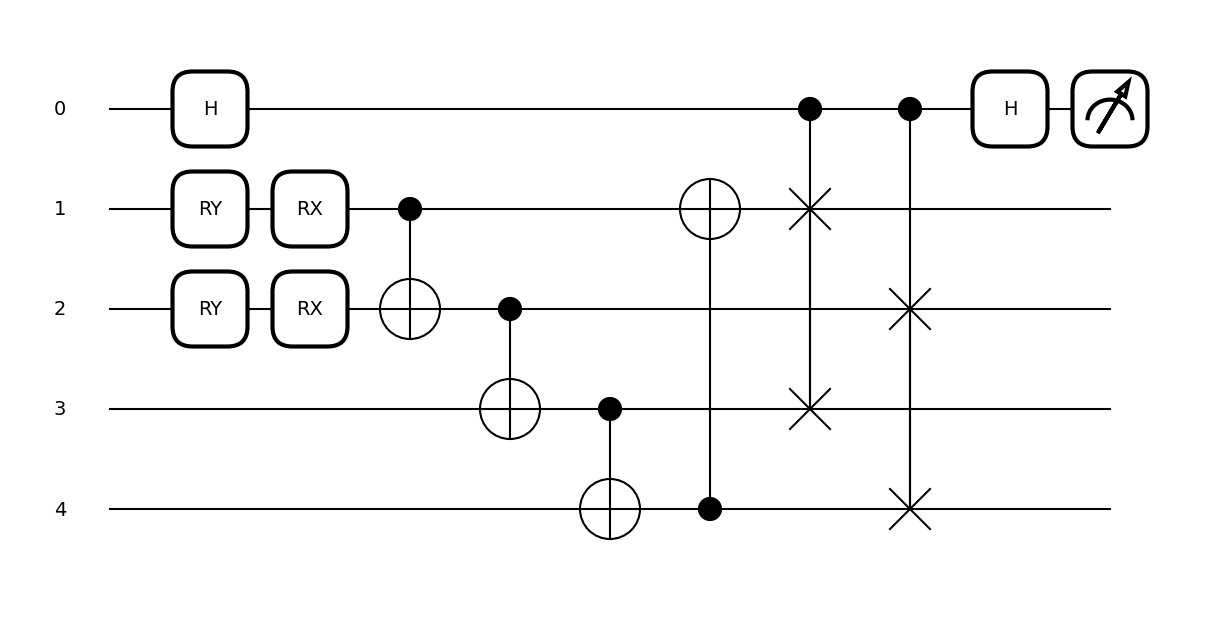

In [ ]:
fig, ax = qml.draw_mpl(qnode)(inputs=[0.5, 0.2], w000=0.1, w001=0.1, w008=0.1, w009=0.1, w016=0.1, w017=0.1, w200=0.1, w201=0.1, w208=0.1, w209=0.1, w216=0.1, w217=0.1)
plt.show()

In [ ]:
circuit_specs = qml.specs(qnode)
print(circuit_specs(inputs=[0.5, 0.2], w000=0.1, w001=0.1, w008=0.1, w009=0.1, w016=0.1, w017=0.1, w200=0.1, w201=0.1, w208=0.1, w209=0.1, w216=0.1, w217=0.1))

{'resources': Resources(num_wires=5, num_gates=12, gate_types=defaultdict(<class 'int'>, {'RY': 2, 'RX': 2, 'CNOT': 4, 'Hadamard': 2, 'CSWAP': 2}), gate_sizes=defaultdict(<class 'int'>, {1: 6, 2: 4, 3: 2}), depth=9, shots=Shots(total_shots=None, shot_vector=())), 'errors': {}, 'num_observables': 1, 'num_diagonalizing_gates': 0, 'num_trainable_params': 0, 'num_device_wires': 5, 'device_name': 'default.qubit', 'expansion_strategy': 'gradient', 'gradient_options': {}, 'interface': 'torch', 'diff_method': 'best', 'gradient_fn': 'backprop'}


#### Random Entanglement

In [ ]:
@qml.qnode(dev)
def qnode(inputs, w000, w001, w008, w009, w016, w017, w200, w201, w208, w209, w216, w217):
    # Input encoding
    qml.RY(inputs[0], wires=1)
    qml.RY(inputs[1], wires=2)

    # Parametrized gates
    qml.RX(w000, wires=1)
    qml.RX(w001, wires=2)

    # Random entanglement
    qml.CNOT(wires=[1, 3])
    qml.CNOT(wires=[2, 4])
    qml.CNOT(wires=[3, 1])
    qml.CNOT(wires=[4, 2])

    # Remaining gates and measurements
    qml.Hadamard(0)
    qml.CSWAP(wires=[0, 1, 3])
    qml.CSWAP(wires=[0, 2, 4])
    qml.Hadamard(0)

    return qml.probs(wires=[0])

weight_shapes = {"w000": 1, "w001": 1, "w008": 1, "w009": 1, "w016": 1, "w017": 1, "w200": 1, "w201": 1, "w208": 1, "w209": 1, "w216": 1, "w217": 1}

In [ ]:
class QuantumGAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

    def forward(self, x):
        out = self.qlayer(x)
        return out

model = QuantumGAN().to(device)

In [ ]:
def save_sample_images(model, epoch, sample_interval=1):
    if epoch % sample_interval == 0:
        num_samples = 10
        sample_indices = np.random.choice(len(pca_data), num_samples, replace=False)
        samples = pca_data[sample_indices]
        descaled_samples = descale_points(samples)

        fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
        for i, sample in enumerate(descaled_samples):
            axes[i].imshow(sample.reshape(16, 16), cmap='viridis')
            axes[i].axis('off')
        plt.tight_layout()
        plt.savefig(f'IQGAN_jet_test_{epoch}.png')
        plt.close()


In [ ]:
def plot_and_save_graphs(loss_list, output_list, fidelity_list, epoch):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(loss_list, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(output_list, label='Output')
    plt.xlabel('Epoch')
    plt.ylabel('Output')
    plt.title('Output over Epochs')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(fidelity_list, label='Fidelity')
    plt.xlabel('Epoch')
    plt.ylabel('Fidelity')
    plt.title('Fidelity over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'IQGAN_jet_test3_plots_{epoch}.png')
    plt.close()


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=30)
highest_acc = 0
loss_list = []
output_list = []
fidelity_list = []
fid_list = []

for epoch in range(epochs):
    loss, output, fidelity = train(model, device, optimizer, epoch)
    loss_list.append(loss)
    output_list.append(output)
    fidelity_list.append(fidelity)

    # Generate samples at each epoch and calculate FID
    generated_samples = generate_samples(model, num_samples=100)
    descaled_generated_samples = descale_points(generated_samples)
    descaled_generated_samples = descaled_generated_samples.reshape(100, 16, 16)

    # Take a batch of real images for comparison
    real_images = X_jet_resized[indices[:100]].cpu().numpy()

    fid = calculate_fid(real_images, descaled_generated_samples)
    fid_list.append(fid)

    print(f'Epoch {epoch}: Loss = {loss}, FID = {fid}')
    save_sample_images(model, epoch, sample_interval=1)

    print("Loss list:", loss_list)
    print("Output list:", output_list)
    print("FID list:", fid_list)
    print("Fidelity list:", fidelity_list)
plot_and_save_graphs(loss_list, output_list, fidelity_list, epoch)

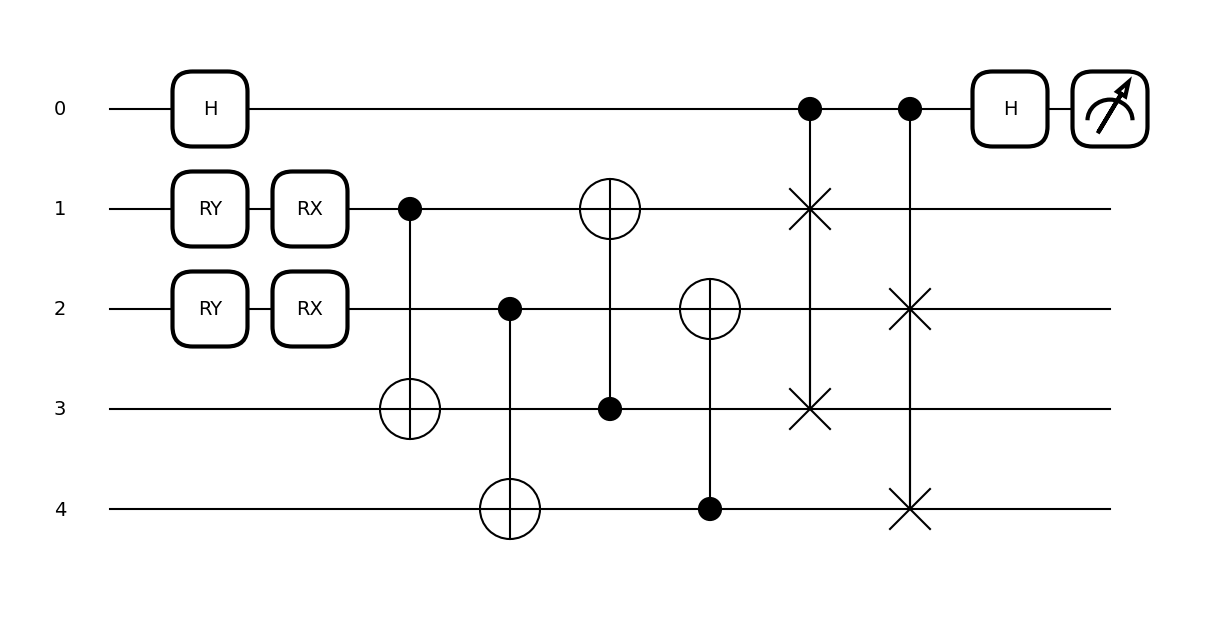

In [ ]:
fig, ax = qml.draw_mpl(qnode)(inputs=[0.5, 0.2], w000=0.1, w001=0.1, w008=0.1, w009=0.1, w016=0.1, w017=0.1, w200=0.1, w201=0.1, w208=0.1, w209=0.1, w216=0.1, w217=0.1)
plt.show()

In [ ]:
circuit_specs = qml.specs(qnode)
print(circuit_specs(inputs=[0.5, 0.2], w000=0.1, w001=0.1, w008=0.1, w009=0.1, w016=0.1, w017=0.1, w200=0.1, w201=0.1, w208=0.1, w209=0.1, w216=0.1, w217=0.1))

{'resources': Resources(num_wires=5, num_gates=12, gate_types=defaultdict(<class 'int'>, {'RY': 2, 'RX': 2, 'CNOT': 4, 'Hadamard': 2, 'CSWAP': 2}), gate_sizes=defaultdict(<class 'int'>, {1: 6, 2: 4, 3: 2}), depth=7, shots=Shots(total_shots=None, shot_vector=())), 'errors': {}, 'num_observables': 1, 'num_diagonalizing_gates': 0, 'num_trainable_params': 0, 'num_device_wires': 5, 'device_name': 'default.qubit', 'expansion_strategy': 'gradient', 'gradient_options': {}, 'interface': 'torch', 'diff_method': 'best', 'gradient_fn': 'backprop'}


#### Linear chain Entanglement

In [ ]:
@qml.qnode(dev)
def qnode(inputs, w000, w001, w008, w009, w016, w017, w200, w201, w208, w209, w216, w217):
    # Input encoding
    qml.RY(inputs[0], wires=1)
    qml.RY(inputs[1], wires=2)

    # Parametrized gates
    qml.RX(w000, wires=1)
    qml.RX(w001, wires=2)

    # Linear chain entanglement
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 4])

    # Remaining gates and measurements
    qml.Hadamard(0)
    qml.CSWAP(wires=[0, 1, 3])
    qml.CSWAP(wires=[0, 2, 4])
    qml.Hadamard(0)

    return qml.probs(wires=[0])

weight_shapes = {"w000": 1, "w001": 1, "w008": 1, "w009": 1, "w016": 1, "w017": 1, "w200": 1, "w201": 1, "w208": 1, "w209": 1, "w216": 1, "w217": 1}

In [ ]:
class QuantumGAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

    def forward(self, x):
        out = self.qlayer(x)
        return out

model = QuantumGAN().to(device)

In [ ]:
def save_sample_images(model, epoch, sample_interval=1):
    if epoch % sample_interval == 0:
        num_samples = 10
        sample_indices = np.random.choice(len(pca_data), num_samples, replace=False)
        samples = pca_data[sample_indices]
        descaled_samples = descale_points(samples)

        fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
        for i, sample in enumerate(descaled_samples):
            axes[i].imshow(sample.reshape(16, 16), cmap='viridis')
            axes[i].axis('off')
        plt.tight_layout()
        plt.savefig(f'IQGAN_jet_test4_{epoch}.png')
        plt.close()


In [ ]:
def plot_and_save_graphs(loss_list, output_list, fidelity_list, epoch):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(loss_list, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(output_list, label='Output')
    plt.xlabel('Epoch')
    plt.ylabel('Output')
    plt.title('Output over Epochs')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(fidelity_list, label='Fidelity')
    plt.xlabel('Epoch')
    plt.ylabel('Fidelity')
    plt.title('Fidelity over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'IQGAN_jet_test4_plots_{epoch}.png')
    plt.close()


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=30)
highest_acc = 0
loss_list = []
output_list = []
fidelity_list = []
fid_list = []

for epoch in range(epochs):
    loss, output, fidelity = train(model, device, optimizer, epoch)
    loss_list.append(loss)
    output_list.append(output)
    fidelity_list.append(fidelity)

    # Generate samples at each epoch and calculate FID
    generated_samples = generate_samples(model, num_samples=100)
    descaled_generated_samples = descale_points(generated_samples)
    descaled_generated_samples = descaled_generated_samples.reshape(100, 16, 16)

    # Take a batch of real images for comparison
    real_images = X_jet_resized[indices[:100]].cpu().numpy()

    fid = calculate_fid(real_images, descaled_generated_samples)
    fid_list.append(fid)

    print(f'Epoch {epoch}: Loss = {loss}, FID = {fid}')
    save_sample_images(model, epoch, sample_interval=1)

    print("Loss list:", loss_list)
    print("Output list:", output_list)
    print("FID list:", fid_list)
    print("Fidelity list:", fidelity_list)
plot_and_save_graphs(loss_list, output_list, fidelity_list, epoch)

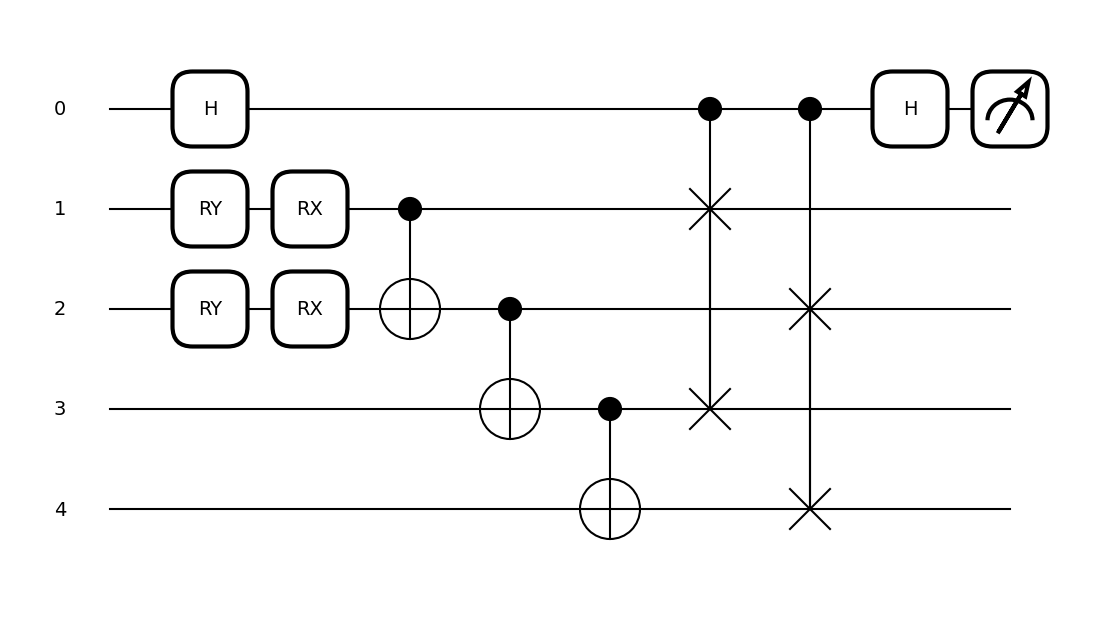

In [ ]:
fig, ax = qml.draw_mpl(qnode)(inputs=[0.5, 0.2], w000=0.1, w001=0.1, w008=0.1, w009=0.1, w016=0.1, w017=0.1, w200=0.1, w201=0.1, w208=0.1, w209=0.1, w216=0.1, w217=0.1)
plt.show()

In [ ]:
circuit_specs = qml.specs(qnode)
print(circuit_specs(inputs=[0.5, 0.2], w000=0.1, w001=0.1, w008=0.1, w009=0.1, w016=0.1, w017=0.1, w200=0.1, w201=0.1, w208=0.1, w209=0.1, w216=0.1, w217=0.1))

{'resources': Resources(num_wires=5, num_gates=11, gate_types=defaultdict(<class 'int'>, {'RY': 2, 'RX': 2, 'CNOT': 3, 'Hadamard': 2, 'CSWAP': 2}), gate_sizes=defaultdict(<class 'int'>, {1: 6, 2: 3, 3: 2}), depth=8, shots=Shots(total_shots=None, shot_vector=())), 'errors': {}, 'num_observables': 1, 'num_diagonalizing_gates': 0, 'num_trainable_params': 0, 'num_device_wires': 5, 'device_name': 'default.qubit', 'expansion_strategy': 'gradient', 'gradient_options': {}, 'interface': 'torch', 'diff_method': 'best', 'gradient_fn': 'backprop'}
